In [10]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import matplotlib.animation as animation
from imutils.object_detection import non_max_suppression
import pytesseract

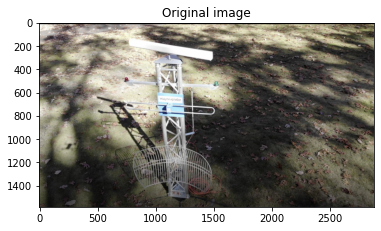

In [3]:
#import and show image
image = cv.imread("mast_frame.png")
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('Original image')
plt.show()

image = cv.cvtColor(image,cv.COLOR_RGB2BGR)

# cv.imshow("test",image)
# cv.waitKey(0)
# cv.destroyAllWindows()

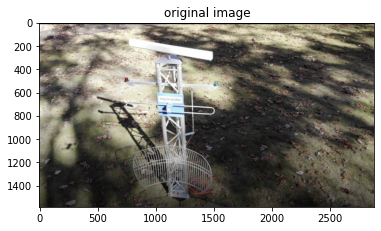

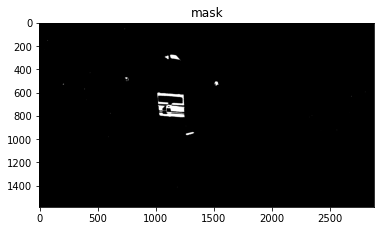

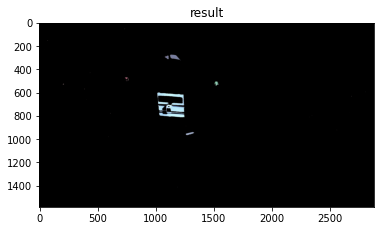

In [7]:
#color filter
def hsv_filter(image, lower = (60,35,140), upper = (180,255,255), show_plots = False):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Threshold of blue in HSV space
    lower_blue = np.array(lower)
    upper_blue = np.array(upper)
    # lower_blue = np.array([110,50,50])
    # upper_blue = np.array([130,255,255])

    # preparing the mask to overlay
    mask = cv.inRange(hsv, lower_blue, upper_blue)
    # mask = cv.cvtColor(image.)

    # The black region in the mask has the value of 0,
    # so when multiplied with original image removes all non-blue regions
    result = cv.bitwise_and(image, image, mask = mask)

    # mask = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
    # result = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # result = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # plt.subplot(311)
    if show_plots:
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.title("original image")
        plt.show()

        # plt.subplot(312)
        plt.imshow(mask, cmap="gray")
        plt.title("mask")
        plt.show()

        # plt.subplot(313)
        plt.imshow(result)
        plt.title("result")
        plt.show()
        
    return result, mask
    # cv.imshow('result',result)
blur = cv.GaussianBlur(image,(5,5),0)
color_filtered, mask = hsv_filter(blur,show_plots=True)

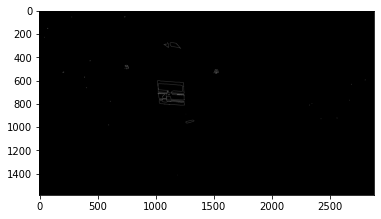

In [22]:
#hugh transform lines
result = cv.cvtColor(color_filtered, cv.COLOR_RGB2BGR)
gray = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
resultCopy = result
 
# Apply edge detection method on the image
edges = cv.Canny(gray, 50, 150, apertureSize=3)
resultCopy = cv.cvtColor(edges, cv.COLOR_BGR2RGB)
plt.imshow(resultCopy) 
plt.show()

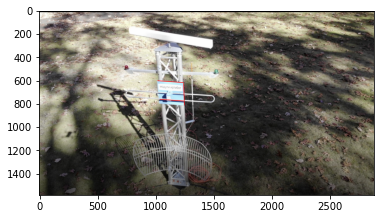

In [34]:
#hugh line finding
linesP = cv.HoughLinesP(edges, 1, np.pi / 180, 50, None, 170, 23)
image = cv.imread("mast_frame.png")
#image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
dstP = image
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(dstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
resultCopy = dstP
resultCopy = cv.cvtColor(resultCopy, cv.COLOR_BGR2RGB)
plt.imshow(resultCopy) 

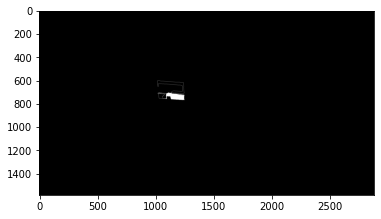

In [21]:
#trying to contour edges
contours = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv.contourArea)

# draw white filled contour o2n black background
result = np.zeros_like(edges)
cv.drawContours(result, [big_contour], 0, (255,255,255), cv.FILLED)
resultCopy = cv.cvtColor(result, cv.COLOR_BGR2RGB)
plt.imshow(resultCopy) 

In [38]:
#trying to do text deterction
#Creating argument dictionary for the default arguments needed in the code. 
args = {"image":"../input/text-detection/example-images/Example-images/ex24.jpg", "east":"/Users/dermotmolony/Downloads/frozen_east_text_detection.pb", "min_confidence":0.1, "width":320, "height":320}

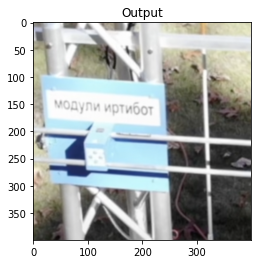

In [39]:
image = cv.imread("mast_frame.png")
#Saving a original image and shape
image = image[500:900, 1000:1400]
orig = image.copy()
(origH, origW) = image.shape[:2]
resultCopy = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(resultCopy)
plt.title('Output')
plt.show()

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

[[ 24 113 102 135]
 [103 116 179 138]]






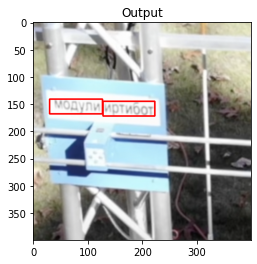

In [47]:
# load the pre-trained EAST model for text detection 
net = cv.dnn.readNet(args["east"])

# The following two layer need to pulled from EAST model for achieving this. 
layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
  
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and a
	return (boxes, confidence_val)

# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)
print(boxes)
##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
# 	r = orig[startY:endY, startX:endX]

# 	#configuration setting to convert image to string.  
# 	configuration = ("-l eng --oem 1 --psm 8")
#     ##This will recognize the text from the image of bounding box
# 	text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), ""))

    #Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
# 	cv.putText(orig_image, text, (start_X, start_Y - 30),
# 		cv.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)
resultCopy = cv.cvtColor(orig_image, cv.COLOR_BGR2RGB)
plt.imshow(resultCopy)
plt.title('Output')2
plt.show()